# Investigating Transfer Learning Capabilities of ViTs(Vision Transformers) and CNNs by Fine-Tuning a Single Trainable Block

In this notebook, we are going to compare a CNN-based model and a transformer-based model for image classification on **CIFAR-10**. The CNN model's backbone is **VGG19**, and **DeiTBaseDistilled** is used as the base for the transformer model. The head of both models are the same. As for the CNN model I encountered out-of-memory errors with a batch size of 512, so I reduced it to 256 for both models.

For both models, the hyperparameters were set as follows:

- Initial learning rate: $10^{-4}$
- Minimum learning rate: $10^{-7}$
- Optimizer: Adam
- Loss function: Cross Entropy
- Maximum number of epochs: 20

## Table of Content
1. [Load and preprocess the dataset](#Dataset)
    - [Data Transforms](#DataTransforms)
    - [Dataset and Dataloader Creation](#DatasetDataloader)
    - [DataLoader](#DataLoader)
    
2. [CNN model fine-tuning](#CNN)
    * [Bulid the VGG19-based model](#VGG19)
    * [Fine-tuning](#CNNFineTune)
    * [Train the VGG19-based Model](#TrainCNN)
    * [Evaluate the VGG19-based Model](#PlotCNNRes)

3. [Transformer model fine-tuning](#Transformer)
    * [Bulid the DeiTBaseDistilled-based model](#DeiTBaseDistilled)
    * [Fine-tuning](#TransFineTune)
    * [Train the DeiTBaseDistilled-based Model](#TrainTransformer)
    * [Evaluate the DeiTBaseDistilled-based Model](#PlotTransformer)

4. [Copame the models](Comparison)
    * [Section 2.1](#section_2_1)

As we are going to use the ```timm``` library for the transformer model, we need to first check the PyTorch version.

In [1]:
import torch
print(torch.__version__)

2.1.2


As long as the version is over 2, everything is ready for the investigation, and we will read the dataset and build the models soon!

But first, let's import the necessary libraries:
- torch: Main library for PyTorch
- time: Library for time-related functions
- nn: Library for neural network modules
- optims: Library for optimization algorithms
- torchvision: Library for computer vision tasks
- tqdm: Library for progress bars
- transforms: Library for data transformations
- vg19: Import VGG19 model
- timm:  Library for pretrained models
- plt: Library for plotting
- DeiTForImageClassificationWithTeacher: For image classification with teacher guidance

In [2]:
import torch         
import time          
import torch.nn as nn 
import torch.optim as optim 
import torchvision   
from tqdm import tqdm 
import numpy as np
import torchvision.transforms as transforms 
from torchvision.models import vgg19  
import timm 
import matplotlib.pyplot as plt
from transformers import DeiTForImageClassificationWithTeacher

Check if a CUDA-capable GPU is available. If available, set the device to "cuda" for GPU processing. Otherwise, set the device to "cpu" for CPU processing.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


To ensure the data is preprocessed consistently and efficiently for training and evaluating a neural network model in PyTorch, we have to follow the below process:
1. Transformation
2. Load Dataset
3. Build DataLoader

Before building the models, we define some useful functions here for future use.

Define a function for counting model's parameters.

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Define a function which plots accuracy and loss during trainnig.

In [5]:
def plot_acc_loss_cnn(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))

    # Plot loss curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    # Plot accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Curves')
    plt.legend()

    plt.show()

In [6]:
def plot_acc_loss_transformer(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Define a function which prints the mean train and validation time.

In [7]:
def report_mean_train_val_time(train_times, val_times):
    mean_train_time = sum(train_times) / len(train_times)
    mean_val_time = sum(val_times) / len(val_times)
    print(f"Mean Train Time: {mean_train_time:.3f} seconds")
    print(f"Mean Validation Time: {mean_val_time:.3f} seconds")

Define a function which gives the model as an input and evaluates it on trainset.

In [8]:
def evaluate_model(model, testloader, base):
    model.eval()
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            if base == "cnn":
                _, predicted = torch.max(outputs.data, 1)
            else:
                logits = outputs.logits
                _, predicted = torch.max(logits, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {test_accuracy}%")

## 1. <a id="Dataset">Load and preprocess the dataset</a>

**Transformation**:
* Resize: Resize images to $224 \times 224$ pixels.
* Randomly flips the images horizontally (only in the training set).
* Converts images to PyTorch tensors and scales pixel values to [0, 1].
* Normalizes the images with the given mean and standard deviation for each channel.

**Note**: For normalizing the CIFAR-10 dataset, we concidered mean and standard deviation for channels RGB as $(0.4914, 0.4822, 0.4465)$ and $(0.2470, 0.2435, 0.2616)$ respectively.

### 1.1. <a id="DataTransforms">Data Transforms</a>

Define the data transformations for training and testing sets.

In [9]:
INPUT_SIZE = (224, 224)
MEAN = (0.4914, 0.4822, 0.4465)
STD  = (0.2470, 0.2435, 0.2616)

Define batch size for both models.

In [10]:
batch_size = 256

In [11]:
train_transform = transforms.Compose(
    [
        transforms.Resize(INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD)
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD)
    ]
)

### 1.2. <a id="DatasetDataloader">Dataset and DataLoader Creation</a>

Load the CIFAR-10 dataset, split train set into training and validation sets, and create data loaders.(80% train, 20% validation)

In [12]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=train_transform)

train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size

train_set, val_set = torch.utils.data.random_split(train_set, [train_size, val_size])

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, transform=test_transform)


100%|██████████| 170498071/170498071 [00:01<00:00, 88866480.24it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data

Files already downloaded and verified


### 1.3. <a id="DataLoader">DataLoader</a>

Iterate over the dataset with batching, shuffling, and parallel data loading.

In [13]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

Let's look what the y_train batchs look like.

In [14]:
for images, labels in trainloader:
    print('Shape of y_train:', labels)
    break 

Shape of y_train: tensor([0, 6, 9, 2, 4, 3, 8, 1, 8, 5, 4, 8, 3, 6, 2, 5, 4, 1, 5, 2, 1, 7, 4, 8,

        8, 4, 3, 0, 3, 4, 7, 6, 5, 3, 4, 1, 4, 2, 7, 1, 7, 3, 8, 2, 6, 2, 2, 1,

        9, 0, 4, 4, 6, 6, 7, 1, 9, 5, 3, 9, 1, 2, 6, 4, 7, 2, 5, 7, 2, 4, 0, 2,

        0, 4, 5, 3, 9, 2, 3, 4, 4, 2, 9, 9, 2, 4, 4, 9, 8, 1, 7, 3, 2, 2, 6, 6,

        8, 9, 7, 8, 9, 8, 6, 4, 5, 0, 4, 3, 1, 4, 2, 3, 8, 7, 8, 9, 5, 0, 6, 9,

        4, 4, 3, 8, 4, 1, 1, 1, 1, 2, 0, 7, 1, 0, 0, 0, 6, 3, 0, 7, 3, 4, 2, 9,

        4, 0, 5, 7, 3, 2, 4, 0, 4, 7, 0, 6, 0, 1, 6, 9, 5, 3, 1, 7, 9, 9, 4, 0,

        3, 2, 9, 4, 7, 1, 2, 4, 6, 2, 1, 6, 3, 4, 5, 4, 4, 3, 1, 7, 0, 6, 2, 6,

        5, 2, 9, 9, 3, 9, 7, 4, 7, 0, 4, 9, 9, 6, 7, 8, 2, 0, 4, 9, 8, 4, 0, 6,

        4, 8, 4, 6, 2, 0, 5, 0, 9, 2, 7, 7, 7, 8, 4, 3, 4, 1, 3, 9, 1, 4, 0, 7,

        1, 8, 7, 9, 4, 1, 3, 5, 2, 6, 7, 0, 6, 2, 6, 0])


As you can see, labels are decimal. But we are going to use ```CrossEntropy``` as the loss function. So, there is no need to convert labels to their one-hot encodings.

## 2. <a id="CNN">CNN model fine-tuning</a>

First of all, the pretrained ```vgg19``` model with ```ImageNet1K``` is loaded. For fine-tuning this model, its last convolution block is unfrozen.


### 2.1. <a id="VGG19">Bulid the VGG19-based model</a>

In [15]:
vgg19_base_model = torchvision.models.vgg19(pretrained=True)

print(vgg19_base_model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth

100%|██████████| 548M/548M [00:03<00:00, 172MB/s]


VGG(

  (features): Sequential(

    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    (1): ReLU(inplace=True)

    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    (3): ReLU(inplace=True)

    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    (6): ReLU(inplace=True)

    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    (8): ReLU(inplace=True)

    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    (11): ReLU(inplace=True)

    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    (13): ReLU(inplace=True)

    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    (15): ReLU(inplace=True)

    (16): Conv2d(256, 256, kernel_size=(3, 3), s

### 2.2. <a id="CNNFineTune">Fine-tuning</a>

As you can see, the last convolution block of this model includes layers 28 to 36. Thus, layers from 28 to the end should be unfrozen which is done like the following:

1. Freeze all layers
2. Unfreeze the last Conv block and the classifier

In [16]:
for param in vgg19_base_model.parameters():
    param.requires_grad = False


for param in vgg19_base_model.features[28:].parameters():
    param.requires_grad = True

Now, for fine-tuning this model, we need to modify its classifier. The paper's recommended structure is given below:

- **Flatten**: Flatten the output of the convolutional layers and transforming the multi-dimensional tensor into a 1D tensor to connect the convolutional part of the model to the fully connected layers.
- **Linear**: A fully connected layer that takes the flattened input from the previous layer. The input size is **512 * 7 * 7**, which corresponds to the number of features output by the convolutional layers. It reduces this to **256*** features.
- **ELU**: An activation function layer that applies the Exponential Linear Unit (ELU) activation function. It is used to introduce non-linearity into the model, which helps it learn complex patterns. It is known for *reducing the vanishing gradient problem* compared to traditional activation functions like ReLU.
- **Dropout**: Prevent overfitting by randomly setting a fraction (50%) of the input units to 0 at each update during training time. This helps in regularizing the model.
- **Linear**: Another fully connected layer that takes the **256** features from the previous layer and maps them to **10** output features. Since we are dealing with CIFAR-10, which has 10 classes, this layer outputs the class scores.


In this structure, there is no need to add ```softmax``` to the model because ```CrossEntropyLoss``` combines LogSoftmax and NLLLoss (Negative Log-Likelihood Loss) in one single class and applying Softmax before CrossEntropyLoss would lead to redundant operations and potentially numerical instability.

In [17]:
class VGG19_CIFAR10(nn.Module):
    def __init__(self, base_model):
        super(VGG19_CIFAR10, self).__init__()
        self.features = base_model.features
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 7 * 7, 256)
        self.elu = nn.ELU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.elu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

cnn_model = VGG19_CIFAR10(vgg19_base_model)

After modifying the model, let's count its number of trainable parameters and print its new structure.

In [18]:
trainable_params = count_parameters(cnn_model)
print("Number of trainable parameters for VGG19 based model:", trainable_params, "\n\n")
print(cnn_model)

Number of trainable parameters for VGG19 based model: 15864586 





VGG19_CIFAR10(

  (features): Sequential(

    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    (1): ReLU(inplace=True)

    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    (3): ReLU(inplace=True)

    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    (6): ReLU(inplace=True)

    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    (8): ReLU(inplace=True)

    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    (11): ReLU(inplace=True)

    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    (13): ReLU(inplace=True)

    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


Before trainnig the model, let's check if the GPU is available and pass the model to the currect device.

In [19]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available! Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")
    
cnn_model.to(device)


print("Model is running on:", next(cnn_model.parameters()).device)

CUDA is available! Using GPU.

Model is running on: cuda:0


### 2.3. <a id="TrainCNN">Train the VGG19-based Model</a>

Set common hyperparameters for both models.

In [20]:
num_epochs = 20     # max number on epochs
initial_lr = 0.0001
min_lr = 0.0000001
loss_function = nn.CrossEntropyLoss()

Consider the optimizer as ```Adam``` and define a scheduler for the VGG19-based model.


In [21]:
# Optimizer
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=initial_lr)

# scheduler
lr_lambda = lambda epoch: max(min_lr / initial_lr, (1 - epoch / num_epochs))
scheduler = torch.optim.lr_scheduler.LambdaLR(cnn_optimizer, lr_lambda=lr_lambda)

Now, let's train the CNN model with the above structure and hyperparameters.

In [22]:
def train_cnn_model(model, num_epochs, trainloader, valloader, patience=5):
    
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_times, val_times = [], []

    # Define a variable which stores best val loss
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        ''' Start of Training Process for an Epoch '''
        start_train_time = time.time()
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        pbar = tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch+1}/{num_epochs} (Train)")
        for i, data in pbar:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the parameter gradients
            cnn_optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            cnn_optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            pbar.set_description(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / (i+1):.4f}')

        train_time = time.time() - start_train_time
        train_times.append(train_time)
        ''' End of Training Process for an Epoch '''

        train_accuracy = 100 * correct_train / total_train
        train_losses.append(running_loss / len(trainloader))
        train_accuracies.append(train_accuracy)

        ''' Start of Validation Process for an Epoch '''
        start_val_time = time.time()
        model.eval()
        val_loss = 0.0
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                loss = loss_function(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_time = time.time() - start_val_time
        val_times.append(val_time)
        ''' End of Validation Process for an Epoch '''

        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss / len(valloader))
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, \
        Train Acc: {train_accuracies[-1]:.2f}, Val Acc: {val_accuracies[-1]:.2f}")

        # Update learning rate scheduler and early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if cnn_optimizer.param_groups[0]['lr'] > min_lr:
            scheduler.step()

        # Check for early stopping
        if epochs_no_improve == patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break

    return train_losses, val_losses, train_accuracies, val_accuracies, train_times, val_times

train_losses, val_losses, train_accuracies, val_accuracies, train_times, val_times = train_cnn_model(cnn_model, num_epochs, trainloader, valloader)

Epoch 1/20, Loss: 0.4741: 100%|██████████| 157/157 [04:18<00:00,  1.64s/it]


Epoch 1/20, Train Loss: 0.4741, Val Loss: 0.3018,         Train Acc: 83.66, Val Acc: 89.64


Epoch 2/20, Loss: 0.2354: 100%|██████████| 157/157 [04:22<00:00,  1.67s/it]


Epoch 2/20, Train Loss: 0.2354, Val Loss: 0.2694,         Train Acc: 92.08, Val Acc: 91.03


Epoch 3/20, Loss: 0.1578: 100%|██████████| 157/157 [04:23<00:00,  1.68s/it]


Epoch 3/20, Train Loss: 0.1578, Val Loss: 0.2577,         Train Acc: 94.67, Val Acc: 91.16


Epoch 4/20, Loss: 0.1102: 100%|██████████| 157/157 [04:23<00:00,  1.68s/it]


Epoch 4/20, Train Loss: 0.1102, Val Loss: 0.2712,         Train Acc: 96.29, Val Acc: 91.20


Epoch 5/20, Loss: 0.0753: 100%|██████████| 157/157 [04:23<00:00,  1.68s/it]


Epoch 5/20, Train Loss: 0.0753, Val Loss: 0.2526,         Train Acc: 97.61, Val Acc: 92.34


Epoch 6/20, Loss: 0.0536: 100%|██████████| 157/157 [04:23<00:00,  1.68s/it]


Epoch 6/20, Train Loss: 0.0536, Val Loss: 0.2621,         Train Acc: 98.23, Val Acc: 91.90


Epoch 7/20, Loss: 0.0345: 100%|██████████| 157/157 [04:23<00:00,  1.68s/it]


Epoch 7/20, Train Loss: 0.0345, Val Loss: 0.3175,         Train Acc: 98.92, Val Acc: 91.81


Epoch 8/20, Loss: 0.0271: 100%|██████████| 157/157 [04:23<00:00,  1.68s/it]


Epoch 8/20, Train Loss: 0.0271, Val Loss: 0.3086,         Train Acc: 99.14, Val Acc: 92.08


Epoch 9/20, Loss: 0.0195: 100%|██████████| 157/157 [04:23<00:00,  1.68s/it]


Epoch 9/20, Train Loss: 0.0195, Val Loss: 0.2912,         Train Acc: 99.45, Val Acc: 92.49


Epoch 10/20, Loss: 0.0122: 100%|██████████| 157/157 [04:23<00:00,  1.68s/it]


Epoch 10/20, Train Loss: 0.0122, Val Loss: 0.3080,         Train Acc: 99.68, Val Acc: 92.87

Early stopping triggered after 10 epochs.


### 2.4. <a id="PlotCNNRes">Evaluate the VGG19-based Model</a>

Plot loss and accuracy during trainnig time fo the CNN model.

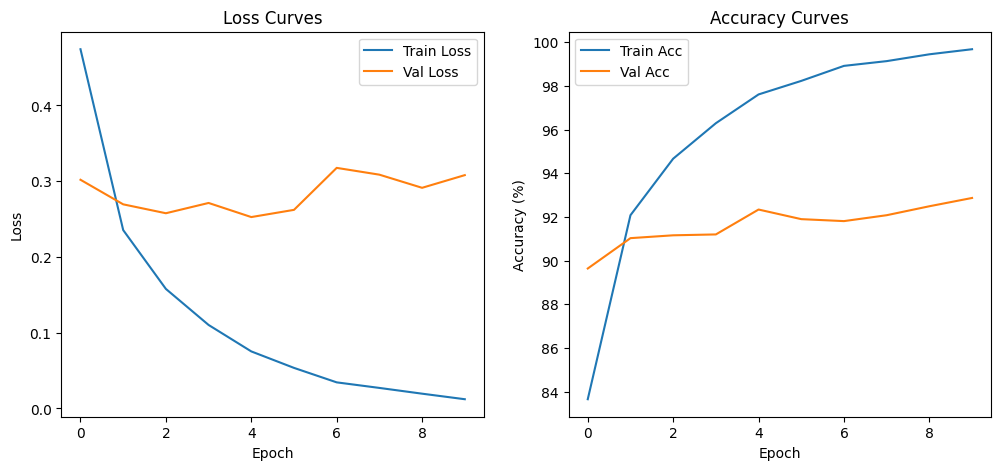

Mean Train Time: 262.763 seconds

Mean Validation Time: 59.575 seconds

VGG19 based model: Finished Training.


In [23]:
plot_acc_loss_cnn(train_losses, val_losses, train_accuracies, val_accuracies)
report_mean_train_val_time(train_times, val_times)

print('VGG19 based model: Finished Training.')

In [24]:
evaluate_model(cnn_model, testloader, "cnn")

Test Accuracy: 92.69%


## 3. <a id="Transformer">Transformer model fine-tuning</a>

### 3.1. <a id="DeiTBaseDistilled">Bulid the DeiTBaseDistilled-based model</a>

Now, let's build the transformer model with base ```DeiTBaseDistilled``` on CIFAR-10 with ImageNet1K weights and evaluate the reults.

In [25]:
transformer_model = DeiTForImageClassificationWithTeacher.from_pretrained('facebook/deit-base-distilled-patch16-224', num_labels=10, ignore_mismatched_sizes=True)

print(transformer_model)

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/349M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

  return self.fget.__get__(instance, owner)()

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:

- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated

- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated

- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated

- disti

DeiTForImageClassificationWithTeacher(

  (deit): DeiTModel(

    (embeddings): DeiTEmbeddings(

      (patch_embeddings): DeiTPatchEmbeddings(

        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

      )

      (dropout): Dropout(p=0.0, inplace=False)

    )

    (encoder): DeiTEncoder(

      (layer): ModuleList(

        (0-11): 12 x DeiTLayer(

          (attention): DeiTSdpaAttention(

            (attention): DeiTSdpaSelfAttention(

              (query): Linear(in_features=768, out_features=768, bias=True)

              (key): Linear(in_features=768, out_features=768, bias=True)

              (value): Linear(in_features=768, out_features=768, bias=True)

              (dropout): Dropout(p=0.0, inplace=False)

            )

            (output): DeiTSelfOutput(

              (dense): Linear(in_features=768, out_features=768, bias=True)

              (dropout): Dropout(p=0.0, inplace=False)

            )

          )

          (intermediate): DeiTIn

Let's unfreeze the 12th transformer block and the classifier layers.

In [ ]:
for name, param in transformer_model.named_parameters():
    if 'layer.11'  in name or 'classifier' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

### 3.2. Number of trainable parameters

In [ ]:
total_trainable_params = count_parameters(transformer_model)
print(f"Total trainable parameters for DeiTBaseDistilled based model: {total_trainable_params}")

Total trainable parameters for DeiTBaseDistilled based model: 7302686


### 3.3. <a id="TransFineTune">Fine-tuning</a>

In [27]:
transformer_model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(768, 256),
    nn.ELU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10),
    nn.Softmax(dim=1)
)

transformer_model.to(device)

DeiTForImageClassificationWithTeacher(
  (deit): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTSdpaAttention(
            (attention): DeiTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
           

In [28]:
for name, param in transformer_model.named_parameters():
    print(name, param.requires_grad)

deit.embeddings.cls_token False

deit.embeddings.distillation_token False

deit.embeddings.position_embeddings False

deit.embeddings.patch_embeddings.projection.weight False

deit.embeddings.patch_embeddings.projection.bias False

deit.encoder.layer.0.attention.attention.query.weight False

deit.encoder.layer.0.attention.attention.query.bias False

deit.encoder.layer.0.attention.attention.key.weight False

deit.encoder.layer.0.attention.attention.key.bias False

deit.encoder.layer.0.attention.attention.value.weight False

deit.encoder.layer.0.attention.attention.value.bias False

deit.encoder.layer.0.attention.output.dense.weight False

deit.encoder.layer.0.attention.output.dense.bias False

deit.encoder.layer.0.intermediate.dense.weight False

deit.encoder.layer.0.intermediate.dense.bias False

deit.encoder.layer.0.output.dense.weight False

deit.encoder.layer.0.output.dense.bias False

deit.encoder.layer.0.layernorm_before.weight False

deit.encoder.layer.0.layernorm_before.bias Fal

### 3.3. <a id="TrainTransformer">Train the DeiTBaseDistilled-based Model</a>

Set the optimizer and scheduler for the transformer model.

In [29]:
# Optimizer
transformer_optimizer = optim.Adam(transformer_model.parameters(), lr=initial_lr)

# Scheduler
scheduler = torch.optim.lr_scheduler.LambdaLR(transformer_optimizer, lr_lambda=lr_lambda)

Pass the model to the current device(CUDA).

In [32]:
transformer_model.to(device)

DeiTForImageClassificationWithTeacher(
  (deit): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTSdpaAttention(
            (attention): DeiTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
           

Let's train the transformer model.

In [35]:
def train_transformer_model(model, trainloader, valloader, num_epochs=20, patience=5, min_lr=1e-6):
    # Define empty lists which store accuracies, losses, and times
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_times, val_times = [], []
    
    training_size = len(trainloader.dataset)
    validation_size = len(valloader.dataset)

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        ''' Start of Training Process for an Epoch '''
        start_train_time = time.time()
        
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        
        train_loader_tqdm = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
        for inputs, labels in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)

            transformer_optimizer.zero_grad()
            outputs = model(inputs)
            logits = outputs.logits
            loss = loss_function(logits, labels)
            loss.backward()
            transformer_optimizer.step()

            # Update loss
            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(logits, 1)
            correct_train += torch.sum(preds == labels)
            total_train += labels.size(0)

            train_loader_tqdm.set_postfix({'Loss': running_loss / training_size})

        end_train_time = time.time()
        ''' End of Training Process for an Epoch '''
        
        # Append the epoch's training time to its corresponding list
        train_times.append(end_train_time - start_train_time)
        
        # Compute epoch's training loss and append it to its corresponding list
        epoch_loss = running_loss / len(trainloader.dataset)
        train_losses.append(epoch_loss)
        
        # Compute epoch's training accuracy and append it to its corresponding list
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy.item())
        
        ''' Start of Validation Process for an Epoch '''
        start_val_time = time.time()
        
        model.eval()
        val_loss = 0.0
        correct = 0
        
        val_loader_tqdm = tqdm(valloader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")
        with torch.no_grad():
            for inputs, labels in val_loader_tqdm:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                logits = outputs.logits  # Extract logits from model output
                loss = loss_function(logits, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(logits, 1)
                correct += torch.sum(preds == labels)

        end_val_time = time.time()
        ''' End of Validation Process for an Epoch '''
        
        # Append the epoch's validation time to its corresponding list
        val_times.append(end_val_time - start_val_time)
        
        # Compute epoch's validation loss and append it to its corresponding list
        val_loss /= len(valloader.dataset)
        val_losses.append(val_loss)
        
        # Compute epoch's validation accuracy and append it to its corresponding list
        val_accuracy = correct.double() / validation_size
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
        
        # Update learning rate scheduler and early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if transformer_optimizer.param_groups[0]['lr'] > min_lr:
            scheduler.step(val_loss)

        # Check for early stopping
        if epochs_no_improve == patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break

    mean_train_time = sum(train_times) / len(train_times)
    mean_val_time = sum(val_times) / len(val_times)
    
    return train_losses, val_losses, train_accuracies, val_accuracies, train_times, val_times

train_losses, val_losses, train_accuracies, val_accuracies, train_times, val_times = train_transformer_model(transformer_model, trainloader, valloader, num_epochs=20)


Epoch 1/20 [Training]: 100%|██████████| 157/157 [08:14<00:00,  3.15s/it, Loss=0.413]

Epoch 1/20 [Validation]: 100%|██████████| 40/40 [01:48<00:00,  2.72s/it]


Epoch 1/20, Train Loss: 0.4129, Train Accuracy: 89.3475, Val Loss: 0.1307, Val Accuracy: 0.9566


Epoch 2/20 [Training]: 100%|██████████| 157/157 [08:13<00:00,  3.15s/it, Loss=0.0969]

Epoch 2/20 [Validation]: 100%|██████████| 40/40 [01:48<00:00,  2.71s/it]


Epoch 2/20, Train Loss: 0.0969, Train Accuracy: 96.7675, Val Loss: 0.1090, Val Accuracy: 0.9638


Epoch 3/20 [Training]: 100%|██████████| 157/157 [08:15<00:00,  3.16s/it, Loss=0.0636]

Epoch 3/20 [Validation]: 100%|██████████| 40/40 [01:49<00:00,  2.73s/it]


Epoch 3/20, Train Loss: 0.0636, Train Accuracy: 97.9325, Val Loss: 0.1086, Val Accuracy: 0.9641


Epoch 4/20 [Training]: 100%|██████████| 157/157 [08:17<00:00,  3.17s/it, Loss=0.0397]

Epoch 4/20 [Validation]: 100%|██████████| 40/40 [01:49<00:00,  2.74s/it]


Epoch 4/20, Train Loss: 0.0397, Train Accuracy: 98.8725, Val Loss: 0.1040, Val Accuracy: 0.9678


Epoch 5/20 [Training]: 100%|██████████| 157/157 [08:16<00:00,  3.16s/it, Loss=0.0222]

Epoch 5/20 [Validation]: 100%|██████████| 40/40 [01:49<00:00,  2.73s/it]


Epoch 5/20, Train Loss: 0.0222, Train Accuracy: 99.4900, Val Loss: 0.1077, Val Accuracy: 0.9663


Epoch 6/20 [Training]: 100%|██████████| 157/157 [08:17<00:00,  3.17s/it, Loss=0.0114]

Epoch 6/20 [Validation]: 100%|██████████| 40/40 [01:49<00:00,  2.74s/it]


Epoch 6/20, Train Loss: 0.0114, Train Accuracy: 99.8625, Val Loss: 0.1124, Val Accuracy: 0.9678


Epoch 7/20 [Training]: 100%|██████████| 157/157 [08:16<00:00,  3.16s/it, Loss=0.00655]

Epoch 7/20 [Validation]: 100%|██████████| 40/40 [01:49<00:00,  2.73s/it]


Epoch 7/20, Train Loss: 0.0066, Train Accuracy: 99.9325, Val Loss: 0.1170, Val Accuracy: 0.9663


Epoch 8/20 [Training]: 100%|██████████| 157/157 [08:17<00:00,  3.17s/it, Loss=0.00406]

Epoch 8/20 [Validation]: 100%|██████████| 40/40 [01:49<00:00,  2.73s/it]


Epoch 8/20, Train Loss: 0.0041, Train Accuracy: 99.9650, Val Loss: 0.1228, Val Accuracy: 0.9669


Epoch 9/20 [Training]: 100%|██████████| 157/157 [08:16<00:00,  3.16s/it, Loss=0.0022]

Epoch 9/20 [Validation]: 100%|██████████| 40/40 [01:49<00:00,  2.73s/it]

Epoch 9/20, Train Loss: 0.0022, Train Accuracy: 99.9950, Val Loss: 0.1245, Val Accuracy: 0.9682

Early stopping triggered after 9 epochs.


As you can see, also in this model the training process paused after 9 epochs. That's because there is no improvement in the validation loss in the last 5 epochs. So, to prevent overfitting, the trainnig process is stopped.

### 3.4. <a id="PlotTransformer">Evaluate the DeiTBaseDistilled-based Model</a>

In [37]:
# Define a function to convert tensors to numpy arrays for plotting the results
def tensor_to_numpy(value):
    if isinstance(value, torch.Tensor):
        return value.cpu().numpy()
    return value

# Convert accuracies to numpy arrays as they are tensors
train_accuracies = [tensor_to_numpy(acc) for acc in train_accuracies]
val_accuracies = [tensor_to_numpy(acc) for acc in val_accuracies]

In [39]:
val_accuracies = [np.ndarray.tolist(val_acc) for val_acc in val_accuracies]
train_accuracies = [acc*1e-2 for acc in train_accuracies]

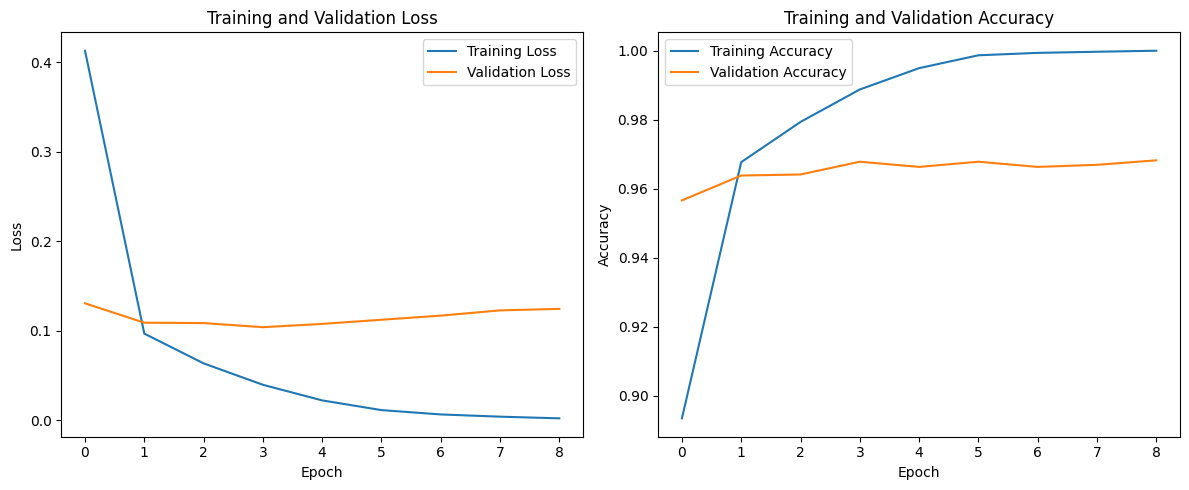

Mean Train Time: 496.143 seconds

Mean Validation Time: 109.225 seconds

DeiTBaseDistilled based model: Finished Training


In [40]:
plot_acc_loss_transformer(train_losses, val_losses, train_accuracies, val_accuracies)
report_mean_train_val_time(train_times, val_times)

print('DeiTBaseDistilled based model: Finished Training')

In [ ]:
evaluate_model(transformer_model, testloader, "transformer")

Test Accuracy: 96.89%
